### Train Image Classifier (Notebook)

This notebook can be used to train a patch-based image classifier on the data downloaded from
CoralNet. The data (images and annotations) must have been downloaded, and using the Annotations
 to Patches Notebook / script, made into patches. 

#### Imports

In [1]:
import os
import glob

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from plot_keras_history import plot_history
from tensorflow.keras.callbacks import *

from plot_keras_history import plot_history
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

from utils import *

In [2]:
print("GPUs: ", tensorflow.config.list_physical_devices('GPU'))

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Setting Data Paths

Here we'll set the path to the directory containing the data for the source we want to use.
In this case, we're using the data downloaded from a downloaded source.

In [3]:
SOURCE_ID = str(4189)

In [4]:
# Root and Source directory
ROOT = "B://CoralNet_Data/"
SOURCE_DIR = ROOT + f"{SOURCE_ID}/"

# Patch dataframe
patches_df = pd.read_csv(SOURCE_DIR + "patches.csv", index_col=0)
patches_df = patches_df.dropna()

# We'll also create folders in this source to hold results of the model
MODEL_DIR = SOURCE_DIR + "model/"
WEIGHTS_DIR = MODEL_DIR + "weights/"
LOGS_DIR = MODEL_DIR + "logs/"

# Make the directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True) 
os.makedirs(LOGS_DIR, exist_ok=True)

#### Prepare Data

Here we'll prepare the data for training. We'll use the annotations to create a dataframe
containing the image names and their labels. We'll then split the data into training, validation,
and testing sets.

In [5]:
image_names = patches_df['Image Name'].unique()

# Split the Images into training, validation, and test sets.
# We split based on the image names, so that we don't have the same image in multiple sets.
training_images, testing_images = train_test_split(image_names, test_size=0.35, random_state=42)
validation_images, testing_images = train_test_split(testing_images, test_size=0.5, random_state=42)

# Create training, validation, and test dataframes
train = patches_df[patches_df['Image Name'].isin(training_images)]
valid = patches_df[patches_df['Image Name'].isin(validation_images)]
test = patches_df[patches_df['Image Name'].isin(testing_images)]

train.reset_index(drop=True, inplace= True)
valid.reset_index(drop=True, inplace= True)
test.reset_index(drop=True, inplace= True)

# The number of class categories
num_classes = len(train['Label'].unique())
print(f"Number of classes: {num_classes}")

Number of classes: 13


#### Data Exploration

As a sanity check, we can see how many images are in each set, and the class distribution.

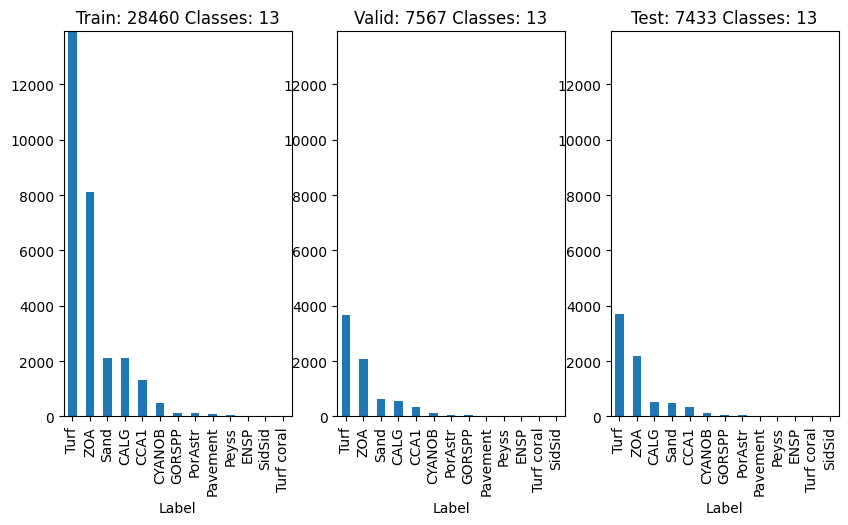

In [6]:
plt.figure(figsize=(10, 5))

# Set the same y-axis limits for all subplots
ymin = 0
ymax = train['Label'].value_counts().max() + 10

# Plotting the train data
plt.subplot(1, 3, 1)
plt.title(f"Train: {len(train)} Classes: {len(train['Label'].unique())}")
ax = train['Label'].value_counts().plot(kind='bar')
ax.set_ylim([ymin, ymax])

# Plotting the valid data
plt.subplot(1, 3, 2)
plt.title(f"Valid: {len(valid)} Classes: {len(valid['Label'].unique())}")
ax = valid['Label'].value_counts().plot(kind='bar')
ax.set_ylim([ymin, ymax])

# Plotting the test data
plt.subplot(1, 3, 3)
plt.title(f"Test: {len(test)} Classes: {len(test['Label'].unique())}")
ax = test['Label'].value_counts().plot(kind='bar')
ax.set_ylim([ymin, ymax])

# Saving and displaying the figure
plt.savefig(LOGS_DIR + "DatasetSplit.png")
plt.show()

#### Data Augmentation

In this cell, we'll use the imgaug library to create augmentation pipelines for the training,
validation, and testing sets. The training set will be augmented more heavily than the validation
and testing sets. We'll also create a data generator for each set, which will read the images
from the dataframe, augment them, and normalize them on-the-fly while training.

Further down, we'll set some model training parameters, such as the number of epochs, batch size,
and learning rate.

In [7]:
# Setting the amount of dropout for our model (form of data augmentation)
dropout_rate = 0.80

# For the training set
augs_for_train = iaa.Sequential([   
                          iaa.Resize(224, interpolation = 'linear'),
                          iaa.Fliplr(0.5),
                          iaa.Flipud(0.5),
                          iaa.Rot90([1, 2, 3, 4], True),
                          iaa.Sometimes(.3, iaa.Affine(scale = (.95, 1.05))),
                       ])

# For the validation and testing sets
augs_for_valid = iaa.Sequential([iaa.Resize(224, interpolation = 'linear')])

In [8]:
# Number of epochs to train for
num_epochs = 25

# Batch size is dependent on the amount of memory available on your machine
batch_size = 32

# Defines the length of an epoch, all images are used
steps_per_epoch_train = len(train)/batch_size
steps_per_epoch_valid = len(valid)/batch_size

# Learning rate 
lr = .0001

# Training images are augmented, and then normalized
train_augmentor = ImageDataGenerator(preprocessing_function = augs_for_train.augment_image)
                                     
                                                                   
# Reading from dataframe
train_generator = train_augmentor.flow_from_dataframe(dataframe = train, 
                                                      directory = None,
                                                      x_col = 'Path',
                                                      y_col = 'Label', 
                                                      target_size = (224, 224), 
                                                      color_mode = "rgb",  
                                                      class_mode = 'categorical', 
                                                      batch_size = batch_size,
                                                      shuffle = True,
                                                      seed = 42)
                                                     
# Only normalize images, no augmentation
validate_augmentor = ImageDataGenerator(preprocessing_function = augs_for_valid.augment_image)

# Reading from dataframe                             
validation_generator = validate_augmentor.flow_from_dataframe(dataframe = valid,
                                                              directory = None, 
                                                              x_col = 'Path',
                                                              y_col = 'Label', 
                                                              target_size = (224, 224), 
                                                              color_mode = "rgb",  
                                                              class_mode = 'categorical', 
                                                              batch_size = batch_size, 
                                                              shuffle = True, 
                                                              seed = 42)

Found 28460 validated image filenames belonging to 13 classes.
Found 7567 validated image filenames belonging to 13 classes.


#### Model Creation

In this cell we'll create the model. We'll use the ConvNeXt architecture, which is a convolutional
neural network that uses grouped convolutions to reduce the number of parameters. We'll use the
pretrained weights from the ImageNet dataset, and we'll freeze the weights of the convolutional
layers. We'll only train the fully-connected layers at the end of the network.

In [9]:
# Now we define the convolutional portion of the model
convnet = tensorflow.keras.applications.convnext.ConvNeXtSmall(
        model_name='convnext_small',
        include_top=False,
        include_preprocessing=True,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='max',
        classes=num_classes,
        classifier_activation='softmax',
)

# Here we create the entire model, with the convnet previously defined
# as the encoder. Our entire model is simple, consisting of the convnet,
# a dropout layer for regularization, and a fully-connected layer with
# softmax activation for classification.
model = Sequential([
        convnet,
        Dropout(dropout_rate),
        Dense(num_classes),
        Activation('softmax')
])

#### Visualizing the Model

If you want, output the model summary to get an idea of the model architecture. This can be
useful as the number of parameters in the model can be quite large, and that may affect the
training time, and the amount of memory required to train the model.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_small (Functional)  (None, 768)              49454688  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 13)                9997      
                                                                 
 activation (Activation)     (None, 13)                0         
                                                                 
Total params: 49,464,685
Trainable params: 49,464,685
Non-trainable params: 0
_________________________________________________________________


#### Defining Callbacks

Here we define the callbacks that will be used during training. The first callback will reduce
the learning rate by N% if the validation loss does not decrease after N epochs. The second callback
will save the model weights after each epoch, but only if the validation loss decreases. The third
callback will stop training if the validation loss does not decrease after N epochs. The fourth
callback will write logs to a Tensorboard log file, which can be used to visualize the training
progress.

In [11]:
callbacks = [
                ReduceLROnPlateau(monitor='val_loss', factor=.65, patience=3, verbose=1),

                ModelCheckpoint(filepath=WEIGHTS_DIR + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                 monitor='val_loss', save_weights_only=True, save_best_only=False, verbose=1),

                EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0,  mode="auto", baseline=None,
                             restore_best_weights=True),

                TensorBoard(log_dir=LOGS_DIR, histogram_freq=0, write_graph=True, write_images=True, update_freq='epoch',
                            profile_batch=2, embeddings_freq=0, embeddings_metadata=None),
            ]

#### Compiling the Model

Here we define the model using the compile function. The compile function is not part of the
model definition, but it is necessary to define the model before training. We use the Adam
optimizer, and the categorical cross-entropy loss function. We also define the metrics that
we want to track during training, in this case accuracy, precision, and recall.

Any adjustments to the model training parameters will require you to recompile the model.

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['acc', precision_m, recall_m])

#### Calculating Class Weights

If you want to calculate the class weights for the training set, you can do so here. The class
weights are used to weight the loss function during training. This is useful if the dataset is
imbalanced, as it will help the model learn the minority classes better. If you do not want to
use class weights, set the weighted variable to False.

In [13]:
# Calculate the class weights, plot and save figure
if True:
    class_weight = compute_class_weights(train)
else:
    class_weight = {c: 1.0 for c in range(num_classes)}

# Reformat for model.fit()
class_weight = {i: list(class_weight.values())[i] for i in range(len(list(class_weight.values())))}

#### Training the Model

In this cell we train the model. We use the fit function to train the model. We pass in the
training and validation generators that we created earlier, as well as the number of epochs
to train for. We also pass in the callbacks that we defined earlier, and the class weights
that we calculated earlier. The fit function will return a history object that we can use
to plot the training and validation loss and accuracy.

In [14]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=steps_per_epoch_valid,
                    callbacks=callbacks,
                    verbose=1,
                    class_weight=class_weight)

Epoch 1/25
890/889 [==============================] - ETA: 0s - loss: 3.4047 - acc: 0.7256 - precision_m: 0.7447 - recall_m: 0.7086
Epoch 1: saving model to B://CoralNet_Data/4189/model/weights\model-001-0.725580-0.783402.h5
889/889 [==============================] - 1151s 1s/step - loss: 3.4047 - acc: 0.7256 - precision_m: 0.7447 - recall_m: 0.7086 - val_loss: 1.1006 - val_acc: 0.7834 - val_precision_m: 0.7862 - val_recall_m: 0.7808 - lr: 1.0000e-04
Epoch 2/25
890/889 [==============================] - ETA: 0s - loss: 2.0365 - acc: 0.7781 - precision_m: 0.8037 - recall_m: 0.7629
Epoch 2: saving model to B://CoralNet_Data/4189/model/weights\model-002-0.778145-0.812079.h5
889/889 [==============================] - 1098s 1s/step - loss: 2.0365 - acc: 0.7781 - precision_m: 0.8037 - recall_m: 0.7629 - val_loss: 0.6690 - val_acc: 0.8121 - val_precision_m: 0.8513 - val_recall_m: 0.7866 - lr: 1.0000e-04
Epoch 3/25
890/889 [==============================] - ETA: 0s - loss: 1.7375 - acc: 0.7987

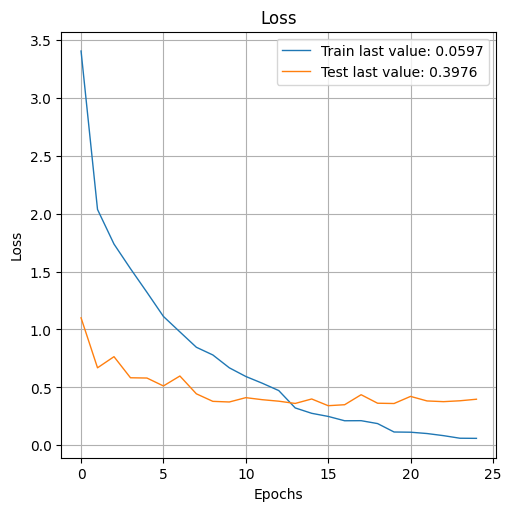

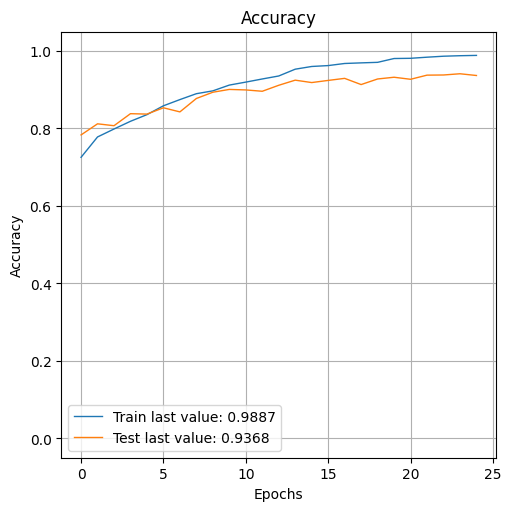

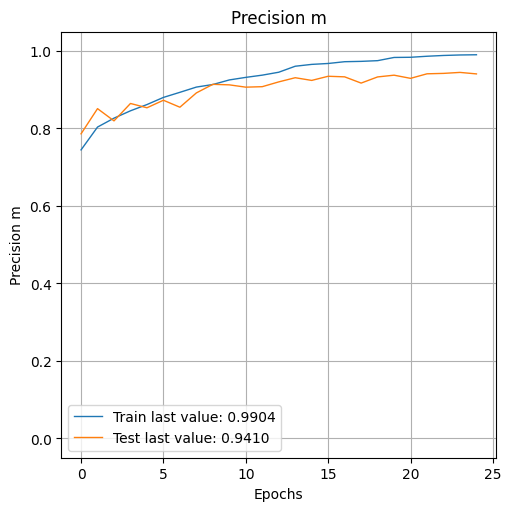

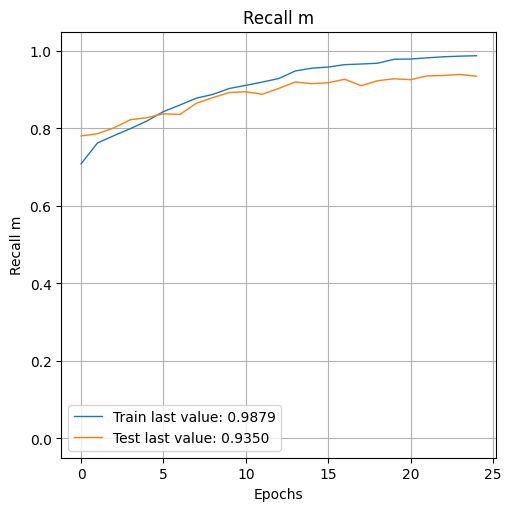

In [15]:
plot_history(history, single_graphs=True, path=f"{LOGS_DIR}")
plt.close()

#### Selecting the Best Weights

After training, we'll select the best weights to use for testing. We'll select the weights
that yield the highest validation accuracy. We'll then load those weights into the model.

In [16]:
# Get the list of weights, sorted by modification time
weights = sorted(glob.glob(WEIGHTS_DIR + "*.h5"), key=os.path.getmtime)
[print(w, i) for i, w in enumerate(weights)];

B://CoralNet_Data/4189/model/weights\model-001-0.725580-0.783402.h5 0
B://CoralNet_Data/4189/model/weights\model-002-0.778145-0.812079.h5 1
B://CoralNet_Data/4189/model/weights\model-003-0.798665-0.807189.h5 2
B://CoralNet_Data/4189/model/weights\model-004-0.818587-0.838245.h5 3
B://CoralNet_Data/4189/model/weights\model-005-0.835769-0.837188.h5 4
B://CoralNet_Data/4189/model/weights\model-006-0.858609-0.853443.h5 5
B://CoralNet_Data/4189/model/weights\model-007-0.874631-0.842870.h5 6
B://CoralNet_Data/4189/model/weights\model-008-0.889845-0.877494.h5 7
B://CoralNet_Data/4189/model/weights\model-009-0.897189-0.893617.h5 8
B://CoralNet_Data/4189/model/weights\model-010-0.912087-0.900885.h5 9
B://CoralNet_Data/4189/model/weights\model-011-0.919782-0.899564.h5 10
B://CoralNet_Data/4189/model/weights\model-012-0.927864-0.896128.h5 11
B://CoralNet_Data/4189/model/weights\model-013-0.935594-0.911590.h5 12
B://CoralNet_Data/4189/model/weights\model-014-0.953127-0.924805.h5 13
B://CoralNet_Dat

In [17]:
# Select the index with the best metrics
best_weights = weights[13]
print("Best Weights: ", best_weights)

# Load into the model
model.load_weights(best_weights)

Best Weights:  B://CoralNet_Data/4189/model/weights\model-014-0.953127-0.924805.h5


#### Testing the Model

Now we create a generator for the test set, and use the model to predict on the test set. We
will print the classification report and plot the confusion matrix.

In [18]:
# Count the occurrences of each label
label_counts = test['Label'].value_counts()

# Sort the DataFrame based on label counts in descending order
test_sorted = test.sort_values(by='Label', key=lambda x: x.map(label_counts), ascending=False)

# Create the generator
test_augmentor = ImageDataGenerator(preprocessing_function = augs_for_valid.augment_image)

test_generator = test_augmentor.flow_from_dataframe(dataframe=test_sorted,
                                                    x_col = 'Path',
                                                    y_col = 'Label',
                                                    target_size = (224, 224),
                                                    color_mode = "rgb",
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    seed = 42)

Found 7433 validated image filenames belonging to 13 classes.


In [19]:
# Use the model to predict on all the test set
predictions = model.predict_generator(test_generator)

# Collapse the probability distribution to the most likely category
predict_classes = np.argmax(predictions, axis = 1)

In [20]:
# Create classification report
report = classification_report(test_generator.classes,
                               predict_classes,
                               target_names=test_generator.class_indices.keys())

# Save the report to a file
with open(f"{LOGS_DIR}Classification_Report.txt", "w") as file:
    file.write(report)

# Display to user
print(report)

              precision    recall  f1-score   support

        CALG       0.83      0.71      0.76       536
        CCA1       0.90      0.71      0.80       327
      CYANOB       0.86      0.42      0.57       116
        ENSP       0.80      0.67      0.73         6
      GORSPP       0.80      0.38      0.51        32
    Pavement       1.00      0.67      0.80        21
       Peyss       0.91      0.71      0.80        14
     PorAstr       0.92      0.75      0.83        32
        Sand       0.94      0.86      0.90       470
      SidSid       1.00      0.75      0.86         4
        Turf       0.91      0.96      0.93      3688
  Turf coral       1.00      0.80      0.89         5
         ZOA       0.93      0.96      0.94      2182

    accuracy                           0.91      7433
   macro avg       0.91      0.72      0.79      7433
weighted avg       0.91      0.91      0.91      7433



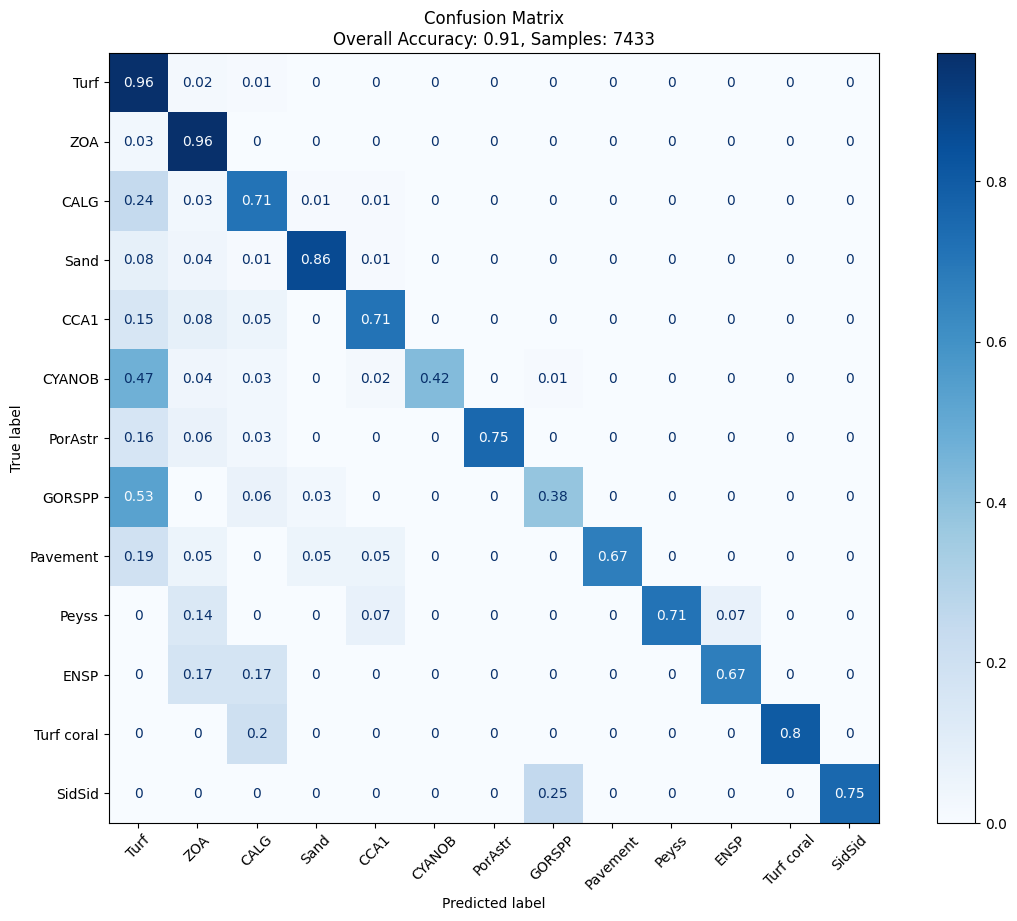

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calculate the overall accuracy
overall_accuracy = accuracy_score(test_generator.classes, predict_classes)
# Calculate the number of samples
num_samples = len(test_generator.classes)
# Convert the accuracy and number of samples to strings
accuracy_str = f"{overall_accuracy:.2f}"
num_samples_str = str(num_samples)

# Calculate the confusion matrix and normalize it
cm = confusion_matrix(test_generator.classes, predict_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, decimals=2)

# Get the sum of each row (number of samples per class)
row_sums = cm.sum(axis=1)

# Sort the confusion matrix and row sums in descending order
sort_indices = np.argsort(row_sums)[::-1]
cm_sorted = cm_normalized[sort_indices][:, sort_indices]
class_labels_sorted = np.array(list(test_generator.class_indices.keys()))[sort_indices]

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=class_labels_sorted)
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title(f"Confusion Matrix\nOverall Accuracy: {accuracy_str}, Samples: {num_samples_str}")
# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig(f"{LOGS_DIR}Confusion_Matrix.png")
plt.show()


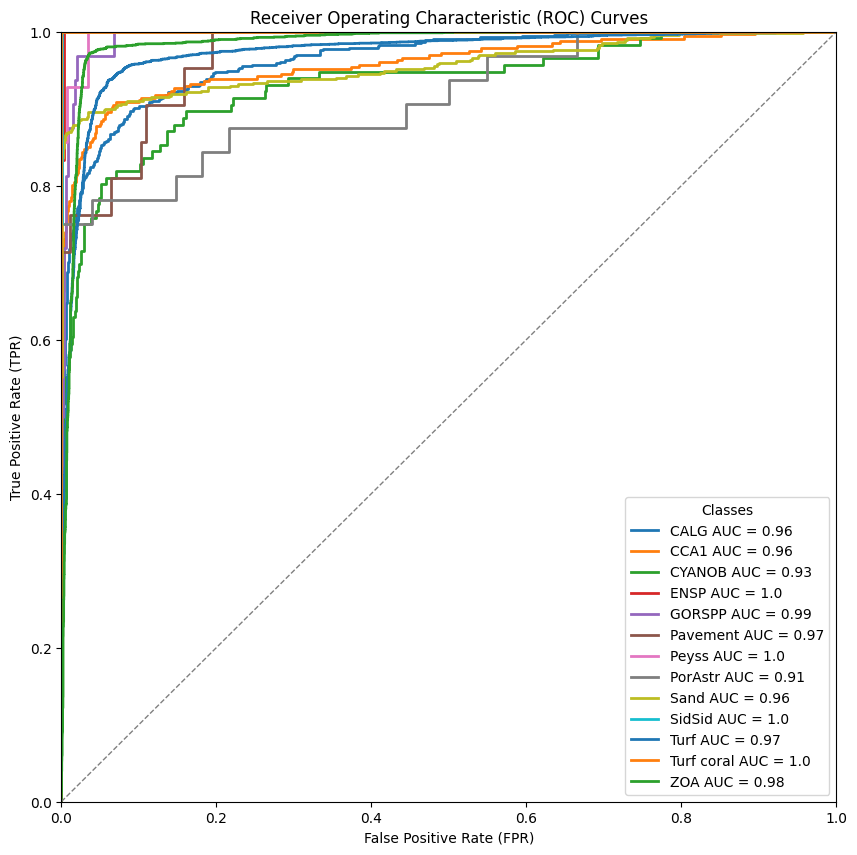

In [22]:
# Convert the true labels to binary format
binary_true_labels = label_binarize(test_generator.classes, classes=np.arange(num_classes))

# Create a dict for the legend
class_indices = {int(v): k for k, v in test_generator.class_indices.items()}

# Compute the false positive rate (FPR), true positive rate (TPR), and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 10))
for i in range(num_classes):
    roc_val = np.around(roc_auc[i], 2)
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_indices[i]} AUC = {roc_val}')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set plot properties
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right', title='Classes')
plt.savefig(LOGS_DIR + "ROC_Curves.png")
plt.show()

#### Confidence Threshold

Here we define a confidence threshold. This is the minimum difference between the most
probably class and the actual class. If the difference is less than this, the model is
unsure of the prediction. We can use this to filter out the predictions that the model is
unsure of, and only use the predictions that the model is sure of. This can be useful if
we want to use the predictions from a model that is not very accurate.

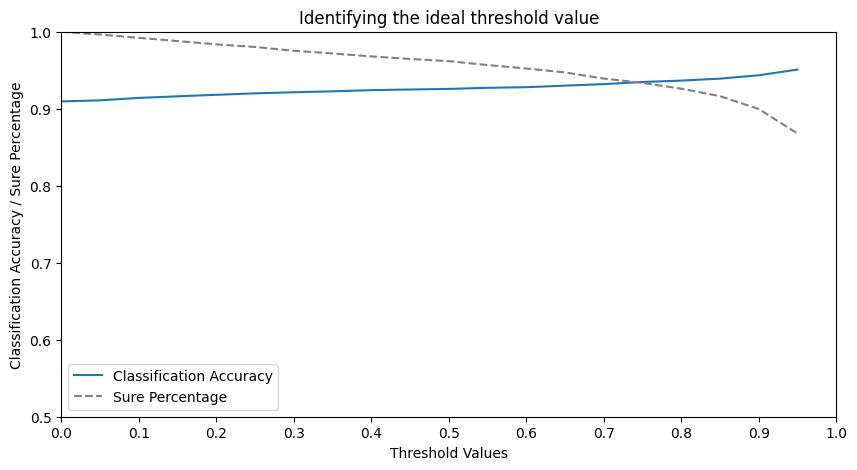

In [24]:
# Higher values represent more sure/confident predictions
# .1 unsure -> .5 pretty sure -> .9 very sure

# Creating a graph of the threshold values and the accuracy
threshold_values = np.arange(0.0, 1.0, 0.05)
class_ACC = []
sure_percentage = []

# Looping through the threshold values and calculating the accuracy and percentage
for threshold in threshold_values:
    # Creating a list to store the sure index
    sure_index = []
    # Looping through all predictions and calculating the sure predictions
    for i in range(0, len(predictions)):
        # If the difference between the most probable class and the second most probable class
        # is greater than the threshold, add it to the sure index
        if (sorted(predictions[i])[-1]) - (sorted(predictions[i])[-2]) > threshold:
            sure_index.append(i)

    # Calculating the accuracy for the threshold value
    sure_test_y = np.take(test_generator.classes, sure_index, axis=0)
    sure_pred_y = np.take(predict_classes, sure_index)
    sure_percentage.append(len(sure_index) / len(predictions))
    class_ACC.append(accuracy_score(sure_test_y, sure_pred_y))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(threshold_values, class_ACC)
plt.plot(threshold_values, sure_percentage, color='gray', linestyle='--')
plt.xlabel('Threshold Values')
plt.xlim([0, 1])
plt.ylim([.5, 1])
plt.xticks(ticks=np.arange(0, 1.05, 0.1))
plt.ylabel('Classification Accuracy / Sure Percentage')
plt.title('Identifying the ideal threshold value')
plt.legend(['Classification Accuracy', 'Sure Percentage'])
plt.savefig(LOGS_DIR + "AccuracyThreshold.png")
plt.show()


#### Saving the Model

Finally, we save the model and the weights. We save the model as a .h5 file.

In [25]:
model.save(f"{MODEL_DIR}Best_Model_and_Weights.h5")